<a href="https://colab.research.google.com/github/ReyhaneTaj/PINNs/blob/main/ln_i__inverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.5 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.066771 s

'compile' took 0.483995 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.42e-01, 0.00e+00, 5.17e+01]    [9.42e-01, 0.00e+00, 5.17e+01]    []  
1000      [1.24e+00, 3.81e-01, 2.27e+00]    [1.24e+00, 3.81e-01, 2.27e+00]    []  
2000      [1.10e+00, 3.35e-01, 2.04e+00]    [1.10e+00, 3.35e-01, 2.04e+00]    []  
3000      [9.99e-01, 3.06e-01, 1.88e+00]    [9.99e-01, 3.06e-01, 1.88e+00]    []  
4000      [9.31e-01, 2.84e-01, 1.75e+00]    [9.31e-01, 2.84e-01, 1.75e+00]    []  
5000      [8.74e-01, 2.67e-01, 1.64e+00]    [8.74e-01, 2.67e-01, 1.64e+00]    []  
6000      [8.25e-01, 2.49e-01, 1.55e+00]    [8.25e-01, 2.49e-01, 1.55e+00]    []  
7000      [7.83e-01, 2.39e-01, 1.47e+00]    [7.83e-01, 2.39e-01, 1.47e+00]    []  
8000      [7.45e-01, 2.28e-01, 1.40e+00]    [7.45e-01, 2.28e-01, 1.40e+00]    []  
9000      [7.12e-01, 2.17e-01, 1.

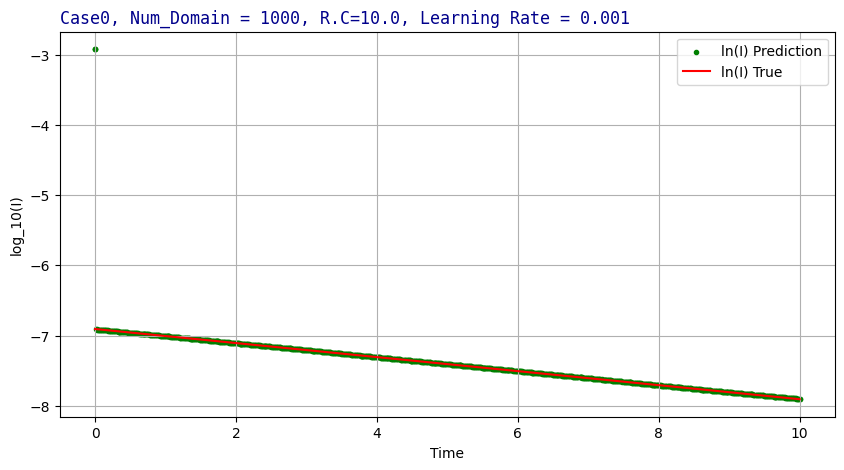

In [ ]:
#.....Ln_Case0.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10.0
N_Domain = 1000
LR = 0.001
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01
n = R_0*C_0
#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, R, C):
    return (-t/ (R*C))+ np.log(U_dc/R)


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 30)  # Adjust the number of points as needed
    ln_I_train = analytical_solution(t, R_0, C_0)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(ln_I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X: tf.math.log(U_dc / R) , boundary, component=0)


# Get the train data
observe_t, ob_ln_I = gen_traindata()
observe_ln_I = dde.icbc.PointSetBC(observe_t, ob_ln_I[:,0:1], component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_ln_I],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [60] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)

#Make true diagram
t_true = np.linspace(0, T, 20).reshape(-1, 1)
ln_I_train = analytical_solution(t_true, R_0, C_0)

# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.plot(t_true, ln_I_train, label='ln(I) True', c='red')


plt.xlabel('Time')
plt.ylabel('log_10(I)')
plt.legend()
plt.title(f'Case0, Num_Domain = {N_Domain}, R.C={n}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()


In [ ]:
!cat variables.dat

0 [1.00e+00, 1.00e+00, 1.00e+00]
600 [1.09e+00, 1.08e+00, 1.08e+00]
1200 [1.14e+00, 1.11e+00, 1.11e+00]
1800 [1.21e+00, 1.16e+00, 1.15e+00]
2400 [1.30e+00, 1.22e+00, 1.21e+00]
3000 [1.41e+00, 1.30e+00, 1.28e+00]
3600 [1.54e+00, 1.41e+00, 1.38e+00]
4200 [1.69e+00, 1.53e+00, 1.49e+00]
4800 [1.86e+00, 1.68e+00, 1.63e+00]
5400 [2.05e+00, 1.85e+00, 1.78e+00]
6000 [2.26e+00, 2.05e+00, 1.96e+00]
6600 [2.50e+00, 2.27e+00, 2.16e+00]
7200 [2.75e+00, 2.51e+00, 2.38e+00]
7800 [3.03e+00, 2.78e+00, 2.61e+00]
8400 [3.32e+00, 3.06e+00, 2.86e+00]
9000 [3.63e+00, 3.37e+00, 3.12e+00]
9600 [3.96e+00, 3.70e+00, 3.39e+00]
10200 [4.30e+00, 4.05e+00, 3.66e+00]
10800 [4.67e+00, 4.41e+00, 3.94e+00]
11400 [5.06e+00, 4.80e+00, 4.22e+00]
12000 [5.46e+00, 5.21e+00, 4.49e+00]
12600 [5.90e+00, 5.65e+00, 4.75e+00]
13200 [6.37e+00, 6.12e+00, 5.01e+00]
13800 [6.87e+00, 6.63e+00, 5.26e+00]
14400 [7.43e+00, 7.19e+00, 5.49e+00]
15000 [8.05e+00, 7.82e+00, 5.72e+00]
15600 [8.74e+00, 8.52e+00, 5.93e+00]
16200 [9.53e+00, 9.32e

In [ ]:
!pip install -q deepxde

Compiling model...
Building feed-forward neural network...
'build' took 0.075035 s

'compile' took 1.783086 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.20e-01, 4.80e-01, 3.15e+01]    [4.20e-01, 4.80e-01, 3.15e+01]    []  
1000      [1.85e+00, 2.19e-02, 6.03e+00]    [1.85e+00, 2.19e-02, 6.03e+00]    []  
2000      [1.41e+00, 1.96e-02, 3.29e+00]    [1.41e+00, 1.96e-02, 3.29e+00]    []  
3000      [1.07e+00, 1.78e-02, 1.98e+00]    [1.07e+00, 1.78e-02, 1.98e+00]    []  
4000      [8.25e-01, 1.62e-02, 1.27e+00]    [8.25e-01, 1.62e-02, 1.27e+00]    []  
5000      [6.02e-01, 1.56e-02, 8.93e-01]    [6.02e-01, 1.56e-02, 8.93e-01]    []  
6000      [4.42e-01, 1.47e-02, 6.64e-01]    [4.42e-01, 1.47e-02, 6.64e-01]    []  
7000      [3.05e-01, 1.59e-02, 5.44e-01]    [3.05e-01, 1.59e-02, 5.44e-01]    []  
8000      [2.28e-01, 1.32e-02, 4.50e-01]    [2.28e-01, 1.32e-02, 4.50e-01]    []  
9000      [1.61e-01, 1.26e-02, 4.

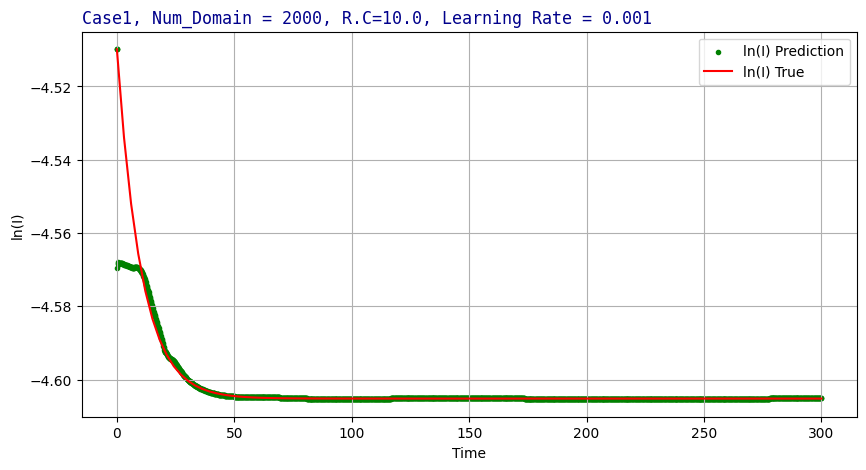

In [ ]:
#.....Ln_Case1.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#Set a seed for reproducibility
#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 300.0
N_Domain = 2000
LR = 0.01
#Define constants for analytical part.
R_0 = 500.0
R_1 = 1000.0
C_1 = 0.01

#Define parameters as variables.
R_r = dde.Variable(1.0)
R = dde.Variable(1.0)
C = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, R_r, R, C):
    return np.log((U_dc/R) * ((np.exp(-t/(R * C)))) + (U_dc/R_r))


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 30)  # Adjust the number of points as needed
    ln_I_train = analytical_solution(t, R_0, R_1, C_1)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(ln_I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + (1/(R*C)*(1 - ((U_dc/R_r) * 1/(tf.exp(ln_I)))))]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X: tf.math.log(U_dc * (1/R_r + 1/R)) , boundary, component=0)


# Get the train data
observe_t, ob_ln_I = gen_traindata()
observe_ln_I = dde.icbc.PointSetBC(observe_t, ob_ln_I[:,0:1], component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_ln_I],
    num_domain = N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R_r, R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)

#Make true diagram
t_true = np.linspace(0, T, 100).reshape(-1, 1)
ln_I_train = analytical_solution(t_true, R_0, R_1, C_1)

# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.plot(t_true, ln_I_train, label='ln(I) True', c='red')


plt.xlabel('Time')
plt.ylabel('ln(I)')
plt.legend()
plt.title(f'Case1, Num_Domain = {N_Domain}, R.C={n}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()


In [ ]:
!cat variables.dat

0 [1.00e+00, 1.00e+00, 1.00e+00]
600 [3.42e+00, 3.62e+00, 3.48e+00]
1200 [4.60e+00, 4.94e+00, 4.56e+00]
1800 [5.50e+00, 5.94e+00, 5.23e+00]
2400 [6.33e+00, 6.85e+00, 5.72e+00]
3000 [7.15e+00, 7.74e+00, 6.11e+00]
3600 [8.01e+00, 8.68e+00, 6.42e+00]
4200 [8.93e+00, 9.69e+00, 6.69e+00]
4800 [9.96e+00, 1.08e+01, 6.93e+00]
5400 [1.11e+01, 1.20e+01, 7.13e+00]
6000 [1.24e+01, 1.34e+01, 7.32e+00]
6600 [1.38e+01, 1.50e+01, 7.49e+00]
7200 [1.54e+01, 1.67e+01, 7.64e+00]
7800 [1.72e+01, 1.87e+01, 7.78e+00]
8400 [1.92e+01, 2.08e+01, 7.91e+00]
9000 [2.14e+01, 2.32e+01, 8.03e+00]
9600 [2.38e+01, 2.57e+01, 8.15e+00]
10200 [2.64e+01, 2.85e+01, 8.25e+00]
10800 [2.93e+01, 3.15e+01, 8.35e+00]
11400 [3.23e+01, 3.47e+01, 8.44e+00]
12000 [3.55e+01, 3.81e+01, 8.52e+00]
12600 [3.89e+01, 4.17e+01, 8.60e+00]
13200 [4.25e+01, 4.55e+01, 8.67e+00]
13800 [4.62e+01, 4.93e+01, 8.73e+00]
14400 [5.01e+01, 5.33e+01, 8.78e+00]
15000 [5.41e+01, 5.74e+01, 8.81e+00]
15600 [5.82e+01, 6.16e+01, 8.83e+00]
16200 [6.24e+01, 6.59e

In [ ]:
!pip install -q deepxde

In [ ]:
#.....Ln_Case2.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#Set a seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 50.0

#Define constants for analytical part.
R_r = 100.0
R_1 = 1000.0
R_2 = 1000.0
C_1 = 0.01
C_2 = 0.01

#Define parameters as variables.
Rr = dde.Variable(1.0)
R1 = dde.Variable(1.0)
R2 = dde.Variable(1.0)
C1 = dde.Variable(1.0)
C2 = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, Rr, R1, R2, C1, C2):
    return [np.log((U_dc/R1) * ((np.exp(-t/(R1 * C1)))) + (U_dc/Rr)), np.log((U_dc/R2) * ((np.exp(-t/(R2 * C2)))))]


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 30)  # Adjust the number of points as needed
    ln_I_train = analytical_solution(t, R_r, R_1 , R_2, C_1, C_2)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(ln_I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I1_t = dde.grad.jacobian(ln_I, t, i=0)
    dln_I2_t = dde.grad.jacobian(ln_I, t, i=1)
    return [dln_I1_t + 1/(R1*C1)*(1 - ((U_dc/Rr) * (tf.exp(-ln_I))))]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X: tf.math.log(U_dc * (1/Rr + 1/R1)) , boundary, component=0)
ic1 = dde.icbc.IC(geom, lambda X: tf.math.log(U_dc * (1/R2)) , boundary, component=1)


# Get the train data
observe_t, ob_ln_I = gen_traindata()
observe_ln_I1 = dde.icbc.PointSetBC(observe_t, ob_ln_I[:,0:1], component=0)
observe_ln_I2 = dde.icbc.PointSetBC(observe_t, ob_ln_I[:,1:2], component=1)

data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, ic1, observe_ln_I1, observe_ln_I2],
    num_domain=1200,
    num_boundary=1,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [2], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [Rr, R1, R2, C1, C2]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=0.01, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)

#Make true diagram
t_true = np.linspace(0, T, 100).reshape(-1, 1)
ln_I_train = analytical_solution(t_true, R_0, R_1, C_1)

# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.plot(t_true, ln_I_train, label='ln(I) True', c='red')


plt.xlabel('Time')
plt.ylabel('ln(I)')
plt.legend()
plt.title('Ln(I), Inverse Discovery')
plt.grid(True)

plt.show()


ValueError: ignored

In this code I removed the boundary condition.

In [ ]:
!pip install -q deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.9 MB/s eta 0:00:00


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.198129 s

'compile' took 0.741908 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.06e+00]    [1.06e+00]    []  
1000      [1.13e-05]    [1.13e-05]    []  
2000      [2.72e-06]    [2.72e-06]    []  
3000      [7.46e-07]    [7.46e-07]    []  
4000      [3.66e-07]    [3.66e-07]    []  
5000      [2.75e-07]    [2.75e-07]    []  
6000      [2.03e-07]    [2.03e-07]    []  
7000      [1.45e-07]    [1.45e-07]    []  
8000      [9.85e-08]    [9.85e-08]    []  
9000      [6.44e-08]    [6.44e-08]    []  
10000     [4.09e-08]    [4.09e-08]    []  
11000     [8.94e-05]    [8.94e-05]    []  
12000     [9.40e-07]    [9.40e-07]    []  
13000     [3.15e-07]    [3.15e-07]    []  
14000     [6.51e-09]    [6.51e-09]    []  
15000     [3.16e-05]    [3.16e-05]    []  
16000     [2.90e-09]    [2.90e-09]    []  
17000     [6.15e-08]    [6.15e-08]    []  
18000     [1.78e-09]    [1.78e-09]    []  
19000     [4.24e-06]    [4.24e-06]    []  
20000     [4.00e-08

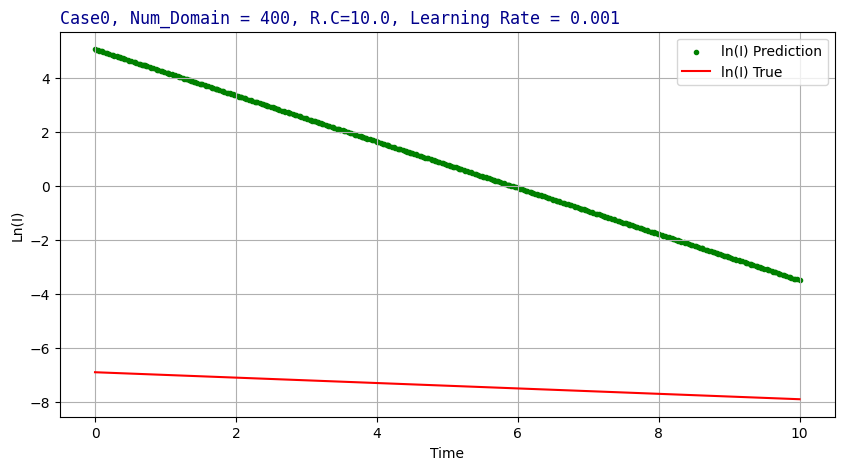

In [2]:
#.....Ln_Case0.....IC_free#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10.0
N_Domain = 400
LR = 0.001
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01
n = R_0*C_0
#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, R, C):
    return (-t/ (R*C))+ np.log(U_dc/R)


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 30)  # Adjust the number of points as needed
    ln_I_train = analytical_solution(t, R_0, C_0)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(ln_I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, ln_I):
    dln_I_t = dde.grad.jacobian(ln_I, t, i=0)
    return [dln_I_t + 1 / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = None

# Get the train data
observe_t, ob_ln_I = gen_traindata()
observe_ln_I = None

data = dde.data.PDE(
    geom,
    Lorenz_system,
    [],
    num_domain=N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=LR, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
ln_I_pred = model.predict(t_test)

#Make true diagram
t_true = np.linspace(0, T, 20).reshape(-1, 1)
ln_I_train = analytical_solution(t_true, R_0, C_0)

# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, ln_I_pred, label='ln(I) Prediction', c='green' , marker='.')
# Plot log(I) True
plt.plot(t_true, ln_I_train, label='ln(I) True', c='red')


plt.xlabel('Time')
plt.ylabel('Ln(I)')
plt.legend()
plt.title(f'Case0, Num_Domain = {N_Domain}, R.C={n}, Learning Rate = {LR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 12})
plt.grid(True)

plt.show()
